# Proyecto 13

## Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

### Instrucciones del proyecto

1. Descargar y limpiar datos: Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos.
3. Entrenar datos: Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos: Utilizando la muestra de prueba y analisis.
5. Concluir.

### Descripción de datos

El dataset posee dos columnas:

| Columna  | Descripción |
|-----------|------------|
| datatime  | Fecha y hora registrada|
| num_orders | Numero de pedidos tomados desde el aeropuerto|


## Descarga y limpieza de datos

In [1]:
# Bibliotecas estandar
import os
import re
import time

# Bibliotecas de terceros
import requests
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
# Constantes
STATE = 31415

### Descarga de datos

In [3]:
# Funcion para descargar dataset
def download_and_save(url: str, filename: str=None) -> None:
    '''Retorna nada
    Función que descarga los dataset desde los links entregados, y los guardará en la carpeta datasets, si esta no existe se creará en la raiz
    :param url: string
    :param filename (optional): string
    :return:Nada
    '''

    if not filename:
        start_index = url.rfind('/') + 1
        filename = url[start_index:].lower()

    directory = 'datasets'
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    full_path = os.path.join(directory,filename)
 
    if os.path.exists(full_path):
        print(f"El archivo {filename} ya existe en {directory}. Descarga cancelada.")
        return
    
    response = requests.get(url)
    if response.status_code == 200:
        
        with open(full_path, 'wb') as file:
            file.write(response.content)
        print(f'Archivos guardado en: {full_path}')
    else:
        print('Error al descargar el archivo')

In [4]:
# URL del dataset
url_dataset = 'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv'

In [5]:
# Ejecutar funcion de descarga
download_and_save(url_dataset)

El archivo taxi.csv ya existe en datasets. Descarga cancelada.


In [6]:
# Carga de DataFrame
df = pd.read_csv(
    './datasets/taxi.csv', index_col=[0], parse_dates=[0]
)

In [7]:
df = df.sort_index()

# Verifica que este ordenado de manera incremental
print(df.index.is_monotonic_increasing)

True


In [8]:
# Muestra inicial
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


### Preparación de datos

In [9]:
# Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
# Muestreo de datos

## Por lo visto anteriormente, el muestreo original esta en un rango de 10 minutos, 
## como se nos solicita entrenar al modelo para predecir en una hora, se remuestrará a 1 cada,
## sumando el numero de ordenes para obtener el total por horas

df = df.resample('1h').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Los datos estan completos, el tipo de datos es correctos y se encuentran ordenados de manera ascendente.

## Analisis de datos

In [11]:
# Copia de df para analisis
data = df.copy()

<Axes: xlabel='datetime'>

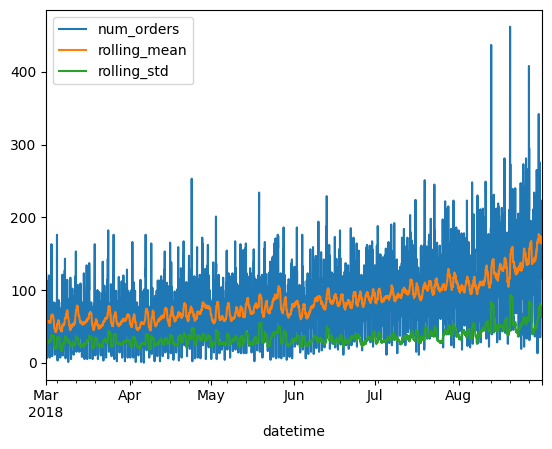

In [12]:
# Plot del df y su media movil
data['rolling_mean'] = data['num_orders'].rolling(24).mean()
data['rolling_std'] = data['num_orders'].rolling(24).std()
data.plot()

Del grafico se puede apreciar que si bien la franja de numeros de viajes es relativamente ancha con una tendencia al aumento, con el grafico de la media movil se refleja de mejor manera esta tendencia, por otro lado la desviacion estandar se mantiene relativamente constante, por lo que se puede asumir que el grafico es madianamente estacionario.

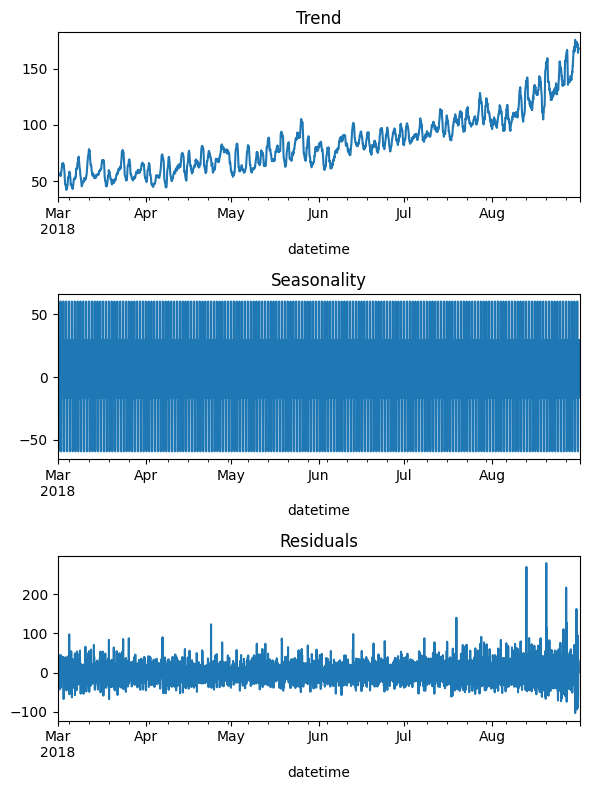

In [13]:
# Analisis de estacionalidad y tendencia
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Se puede apreciar una tendencia al alza, en cuanto a la estacionalidad es dificil notar el patron, aunque se puede notar que aproximadamente hay 4-5 franjas mas oscuras que se repiten por mes, por lo que se analizará en un rango de 10 dias

<Axes: xlabel='datetime'>

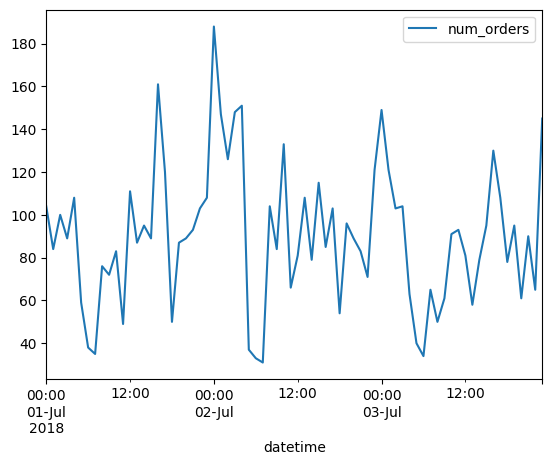

In [14]:
df['2018-07-01':'2018-07-03'].plot()

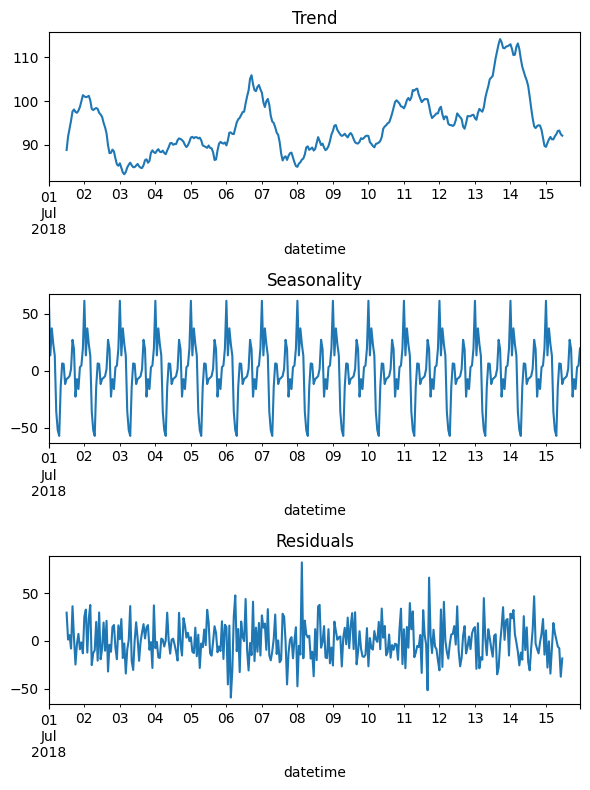

In [15]:
# Analisis de estacionalidad y tendencia

decomposed = seasonal_decompose(df['2018-07-01':'2018-07-15'])

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

El grafico muestra los datos desde el dia Domingo 1 de Julio hasta el dia domingo 15 de Julio
Aqui se logra apreción de mejor manera que hay patrones que se repiten semanalmente, lo cuales parecen repetirse los fines de semana.

## Entrenamiento de datos

In [16]:
# Funcion para calcular rmse
def print_rmse(target_values: pd.Series, predicted_values: pd.Series) -> float:
    """
    Calcula y devuelve el valor RMSE entre los datos reales y una preidcción realizada or un modelo de ML
    Parametros:
    target_values (panda.Series): Conjunto de valores reales del objetivo
    predicted_values (panda.Series): Predicciones realizadas
    """
    print( f'El RMSE calculado es: {round(mean_squared_error(target_values, predicted_values)**0.5,2)}')
    return mean_squared_error(target_values, predicted_values)**0.5

In [17]:
# Funcion para estimar entrenar, predecir y calcular tiempos

def train_pred_time(model_f :BaseEstimator, features_train_f: pd.DataFrame, target_train_f: pd.Series, features_test_f: pd.DataFrame) :
    """
    Genera el entrenamiento de un modelo de ML, ingresando las caracteristicas y objetivos de entrenamiento, para luego generar una prediccion
    con el modelo utilizando las caracteristicas de prueba. A su vez calcula el tiempo entre cada evento para devolver los tiempos 
    de entranmiento, de prediccion ademas de la predicción en si.
    Parametros:
    model: modelo de ML a utlizar
    features_train: Conjunto de entrenamiento
    target_train: Objetivo de entrenamiento
    features_test: Conjunto de pruebas
    """
    times_dict = {}
    prediction_dict = {}
    

    train_start_time = time.perf_counter()
    model_f.fit(features_train_f, target_train_f)
    train_end_time = time.perf_counter()

    prediction_start_time = time.perf_counter()
    prediction_dict['test'] = model_f.predict(features_test_f)
    prediction_end_time = time.perf_counter()

    prediction_dict['train'] = model_f.predict(features_train_f)

    times_dict['train'] = train_end_time - train_start_time
    times_dict['predict'] = prediction_end_time - prediction_start_time

    print(f"Tiempo de entrenamiento: {round(times_dict['train'], 4)} s")
    print(f"Tiempo de predicción: {round(times_dict['predict'], 4)} s")
    
    return times_dict, prediction_dict

In [18]:
def test_parameters(model:BaseEstimator, param_grid:dict, features_train:pd.DataFrame, target_train:pd.Series) -> None:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3)
    grid_search.fit(features_train, target_train)
    best_params = grid_search.best_params_

    print("Mejores hiperparámetros encontrados:")
    print(best_params)
    return best_params

#### Preparación de datos

In [19]:
# Funcion que prepara el dataframe para su entrenamiento
def make_features(df: pd.DataFrame, max_lag: int, rolling_mean_size: int) -> None:
    """
    Preparacíon de df para entrenamiento, separando la informacion de las fechas,
    ingresando lags de los datos a cada caracteristica y obteniendo la media
    movil
    """
    # Informacion de la fecha
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    # Un lag de cierta cantidad de dias
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
		
    # La media movil del rango anterior a la fecha
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [20]:
# Preparando caracteristicas
## Como existe cierto nivel de estacionalidad diaria el max_lag que se utilizará será de 24
## y una media movil de 7 para tener una alta receptividad a los cambios
make_features(df, 24, 7)

print(f'Tamaños dataframe: {df.shape}')

# Set de entrenamiento y pruebas
train, temporal = train_test_split(df, shuffle=False, test_size=0.2)
validation, test = train_test_split(temporal, shuffle=False, test_size=0.5)

train.dropna(inplace=True)

print(f'Tamaños conjunto de entrenamiento: {train.shape}')
print(f'Tamaños conjunto de validación: {validation.shape}')
print(f'Tamaños conjunto de prueba: {test.shape}')


Tamaños dataframe: (4416, 31)
Tamaños conjunto de entrenamiento: (3508, 31)
Tamaños conjunto de validación: (442, 31)
Tamaños conjunto de prueba: (442, 31)


In [21]:
# Seteo de caracteristicas y objetivos
features_train = train.drop(['num_orders'], axis=1)
features_validation = validation.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders']
target_validation = validation['num_orders']
target_test = test['num_orders']

 <div class="alert alert-block alert-info">

 <b>Segun lo requerido, se crea conjunto de validacion, el cual es el utilizado para la seleccion del mejor modelo</b> <a class="tocSkip"></a>

 </div>

In [22]:
#Verifica que los tiempos estas correctos
print(features_train.tail(1).index)
print(features_validation.head(1).index)
print(features_validation.tail(1).index)
print(features_test.head(1).index)

DatetimeIndex(['2018-07-26 03:00:00'], dtype='datetime64[ns]', name='datetime', freq='h')
DatetimeIndex(['2018-07-26 04:00:00'], dtype='datetime64[ns]', name='datetime', freq='h')
DatetimeIndex(['2018-08-13 13:00:00'], dtype='datetime64[ns]', name='datetime', freq='h')
DatetimeIndex(['2018-08-13 14:00:00'], dtype='datetime64[ns]', name='datetime', freq='h')


In [23]:
#Se declara esta lista donde se irán ingresando los valores de los tiempos y caracteristicas principales de cada modelo
data_models = []

### Modelo de regresión lineal

Siguiendo la logica del proyecto anterior, como se deben evaluar diferentes modelos, con distintos hiperparametros, se utilizará el modelo de regresion lineal como prueba de cordura.

In [24]:
# Declaración de modelo
model_lr = LinearRegression()

In [25]:
# Entrenamiento y prediccion
times_lr, predictions_lr = train_pred_time(model_lr, features_train, target_train, features_validation)

Tiempo de entrenamiento: 0.0171 s
Tiempo de predicción: 0.0024 s


In [26]:
#RMSE
print('RMSE con conjunto de entrenamiento:')
rmse_train_lr = print_rmse(target_train, predictions_lr['train'])
print('RMSE con conjunto de pruebas:')
rmse_validation_lr = print_rmse(target_validation, predictions_lr['test'])

RMSE con conjunto de entrenamiento:
El RMSE calculado es: 24.46
RMSE con conjunto de pruebas:
El RMSE calculado es: 34.15


In [27]:
# Guardar datos
data_models.append(['linear_regression', times_lr['train'], times_lr['predict'], rmse_train_lr, rmse_validation_lr])

Con este resultado se ya se cumple el requerimiento minimo de RMSE para el conjunto de pruebas y un resultado muy superior para el conjunto de entrenamiento, esto puede ser prueba se un sobreajuste del modelo. Aunque esto nos servirá como prueba de cordura.

### Modelo de Arbol de Desiciones

Ajuste de hiperparametros:

 - max_depth:  corresponde a la distancia maxima entre la raiz (entrada) y cualquier nodo, ayuda a controlar el sobreajuste limitando la complejidad del modelo.

In [28]:
# Declaracion del modelo
model_dt = DecisionTreeRegressor(random_state=STATE)
# Declaracion de rango de hiperparametros
param_grid_dt = {
    'max_depth': list(range(2, 51, 2)),
}

In [29]:
# testeo de hiperparametros
best_params_dt = test_parameters(model_dt, param_grid_dt, features_train,target_train)

Mejores hiperparámetros encontrados:
{'max_depth': 4}


In [30]:
# Se ejecuta el modelo con los mejores hiperparametros encontrados.
model_dt = DecisionTreeRegressor(**best_params_dt, random_state=STATE)
times_dt, predictions_dt = train_pred_time(model_dt, features_train, target_train, features_validation)

Tiempo de entrenamiento: 0.0318 s
Tiempo de predicción: 0.0029 s


In [31]:
#RMSE
print('RMSE con conjunto de entrenamiento:')
rmse_train_dt = print_rmse(target_train, predictions_dt['train'])
print('RMSE con conjunto de pruebas:')
rmse_validation_dt = print_rmse(target_validation, predictions_dt['test'])

RMSE con conjunto de entrenamiento:
El RMSE calculado es: 24.05
RMSE con conjunto de pruebas:
El RMSE calculado es: 40.68


In [32]:
# Guardar datos
data_models.append(['desicion_tree', times_dt['train'], times_dt['predict'], rmse_train_dt, rmse_validation_dt])

Este modelo no fue tan efectiva para este caso, obteniendo un valor RMSE por sobre la prueba de cordura y el minimo requerido.

### Modelo de Bosque aleatorio

Ajuste de hiperparametros:

 - max_depth: corresponde a la distancia maxima entre la raiz (entrada) y cualquier nodo de cada arbol, ayuda a controlar el sobreajuste limitando la complejidad del modelo.
 - n_estimators: corresponde al numero de arboles de desicion que se utilizarán para entrenar el modelo, cada arbol utilizará una parte del conjunto de entrenamiento, permite controlar el sobre y sub ajuste.

In [33]:
# Declaracion del modelo
model_rf = RandomForestRegressor(random_state=STATE)
# Declaracion de rango de hiperparametros
param_grid_rf = {
    'n_estimators': list(range(30, 41, 2)),
    'max_depth': list(range(10, 21, 2)),
}

In [34]:
# testeo de hiperparametros
best_params_rf = test_parameters(model_rf, param_grid_rf, features_train,target_train)

Mejores hiperparámetros encontrados:
{'max_depth': 12, 'n_estimators': 38}


In [35]:
model_rf = RandomForestRegressor(**best_params_rf, random_state=STATE)
times_rf, predictions_rf = train_pred_time(model_rf, features_train, target_train, features_validation)

Tiempo de entrenamiento: 1.2694 s
Tiempo de predicción: 0.0035 s


In [36]:
#RMSE
print('RMSE con conjunto de entrenamiento:')
rmse_train_rf = print_rmse(target_train, predictions_rf['train'])
print('RMSE con conjunto de pruebas:')
rmse_validation_rf = print_rmse(target_validation, predictions_rf['test'])

RMSE con conjunto de entrenamiento:
El RMSE calculado es: 11.9
RMSE con conjunto de pruebas:
El RMSE calculado es: 33.11


In [37]:
# Guardar datos
data_models.append(['random_forest', times_rf['train'], times_rf['predict'], rmse_train_rf, rmse_validation_rf])

Este modelo tienen un mejor desempeño que su contraparte de un solo arbol, mejorando la prueba de cordura.

### Modelo LightGBM

Esta biblioteca utiliza algoritmos de boosting para modelos de arbol de decision.

Ajuste de hiperparametros:

 - max_depth: corresponde a la distancia maxima entre la raiz (entrada) y cualquier nodo de cada arbol, ayuda a controlar el sobreajuste limitando la complejidad del modelo.
 - num_leaves: corresponde al numero de hojas que tendrá cada arbol. ayuda a controlar el sobreajuste del modelo.
 - n_estimators: define cuantos arboles se utilizarán en el modelo.
 - learning_rate: la tasa de aprendizaje regula la velocidad de ajuste del modelo, una baja tasa provoca un aprendizaje mas lento pero robusto, mientras que una tasa alta aumentará la velocidad de aprendizaje con riesgo a sobreajuste.

In [38]:
# Declaracion del modelo
model_lgbm = lgb.LGBMRegressor(boosting_type='gbdt', random_state=STATE, force_row_wise=True, verbose=-1)
# Declaracion de rango de hiperparametros
param_grid_lgbm = {
    'max_depth': [10, 20, 30],
    'num_leaves': [10, 20, 30],
    'n_estimators': [10, 100, 1000],
    'learning_rate': [0.1, 0.2]
}

In [39]:
# testeo de hiperparametros
best_params_lgbm = test_parameters(model_lgbm, param_grid_lgbm, features_train,target_train)

Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 10}


In [40]:
model_lgbm = lgb.LGBMRegressor(**best_params_lgbm, boosting_type='gbdt', random_state=STATE, force_row_wise=True, verbose=-1)
times_lgbm, predictions_lgbm = train_pred_time(model_lgbm, features_train, target_train, features_validation)

Tiempo de entrenamiento: 0.0473 s
Tiempo de predicción: 0.002 s


In [41]:
#RMSE
print('RMSE con conjunto de entrenamiento:')
rmse_train_lgbm = print_rmse(target_train, predictions_lgbm['train'])
print('RMSE con conjunto de pruebas:')
rmse_validation_lgbm = print_rmse(target_validation, predictions_lgbm['test'])

RMSE con conjunto de entrenamiento:
El RMSE calculado es: 17.21
RMSE con conjunto de pruebas:
El RMSE calculado es: 32.17


In [42]:
# Guardar datos
data_models.append(['lgbm', times_lgbm['train'], times_lgbm['predict'], rmse_train_lgbm, rmse_validation_lgbm])

En este modelo se aprecia una mejora consirable, se puede ver que esta menos sobreajustado que los modelos anteriores, ya que no se ajusta tanto a los valores con los que fue entrenado pero mejora con respecto a los otros modelos su resultado con el conjunto de pruebas.

### Modelo Catboost

Ajuste de hiperparametros:

 - iterations: define cuantos arboles (o iteraciones) se utilizarán en el modelo.
 - learning_rate: la tasa de aprendizaje regula la velocidad de ajuste del modelo, una baja tasa provoca un aprendizaje mas lento pero robusto, mientras que una tasa alta aumentará la velocidad de aprendizaje con riesgo a sobreajuste.
 - max_depth: corresponde a la distancia maxima entre la raiz (entrada) y cualquier nodo de cada arbol, ayuda a controlar el sobreajuste limitando la complejidad del modelo.

In [43]:
# Modifcar del modelo, quitar cat_features
model_cb = CatBoostRegressor( random_state=STATE, verbose=False,loss_function='RMSE')

param_grid_cb = {
    'iterations': [10, 100, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [1,5,10],
}

In [44]:
# testeo de hiperparametros
best_params_cb = test_parameters(model_cb, param_grid_cb, features_train,target_train)

Mejores hiperparámetros encontrados:
{'depth': 5, 'iterations': 500, 'learning_rate': 0.1}


In [45]:
model_cb = CatBoostRegressor(**best_params_cb, random_state=STATE, verbose=False,loss_function='RMSE')
times_cb, predictions_cb = train_pred_time(model_cb, features_train, target_train, features_validation)

Tiempo de entrenamiento: 0.7281 s
Tiempo de predicción: 0.0019 s


In [46]:
#RMSE
print('RMSE con conjunto de entrenamiento:')
rmse_train_cb = print_rmse(target_train, predictions_cb['train'])
print('RMSE con conjunto de pruebas:')
rmse_validation_cb = print_rmse(target_validation, predictions_cb['test'])

RMSE con conjunto de entrenamiento:
El RMSE calculado es: 11.91
RMSE con conjunto de pruebas:
El RMSE calculado es: 30.96


In [47]:
# Guardar datos
data_models.append(['catboost', times_cb['train'], times_cb['predict'], rmse_train_cb, rmse_validation_cb])

### Modelo XGBoost

Ajuste de hiperparametros:

 - n_estimators: define cuantos arboles (o iteraciones) se utilizarán en el modelo.
 - max_depth: corresponde a la distancia maxima entre la raiz (entrada) y cualquier nodo de cada arbol, ayuda a controlar el sobreajuste limitando la complejidad del modelo.
 - learning_rate: la tasa de aprendizaje regula la velocidad de ajuste del modelo, una baja tasa provoca un aprendizaje mas lento pero robusto, mientras que una tasa alta aumentará la velocidad de aprendizaje con riesgo a sobreajuste.

In [48]:
# Declaracion del modelo
model_xgb = xgb.XGBRegressor( random_state=STATE, eval_metric='rmse')
# Declaracion de rango de hiperparametros
param_grid_xgb = {
    'n_estimators': [10, 100, 500],
    'max_depth': [1,5,10],
    'learning_rate': [0.01, 0.1, 0.5],
}

In [49]:
# testeo de hiperparametros
best_params_xgb = test_parameters(model_xgb, param_grid_xgb, features_train,target_train)

Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [50]:
model_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=STATE, eval_metric='rmse')
times_xgb, predictions_xgb = train_pred_time(model_xgb, features_train, target_train, features_validation)

Tiempo de entrenamiento: 0.1035 s
Tiempo de predicción: 0.0041 s


In [51]:
#RMSE
print('RMSE con conjunto de entrenamiento:')
rmse_train_xgb = print_rmse(target_train, predictions_xgb['train'])
print('RMSE con conjunto de pruebas:')
rmse_validation_xgb = print_rmse(target_validation, predictions_xgb['test'])

RMSE con conjunto de entrenamiento:
El RMSE calculado es: 13.52
RMSE con conjunto de pruebas:
El RMSE calculado es: 31.92


In [52]:
# Guardar datos
data_models.append(['xgboost', times_xgb['train'], times_xgb['predict'], rmse_train_xgb, rmse_validation_xgb])

## Analisis de resultados

In [53]:
models_df = pd.DataFrame(data_models, columns=['model','training_time','prediction_time','rmse_train', 'rmse_validation'])
models_df

,model,training_time,prediction_time,rmse_train,rmse_validation
0,linear_regression,0.017052,0.002421,24.462361,34.154522
1,desicion_tree,0.031832,0.002946,24.048213,40.676586
2,random_forest,1.269450,0.003487,11.902896,33.108345
3,lgbm,0.047268,0.002032,17.213070,32.169226
4,catboost,0.728149,0.001931,11.914482,30.960734
5,xgboost,0.103454,0.004063,13.524193,31.919279


Analisis de metrica

Analizando de manera similar al proyecto anterior, se almacenaron los valores de resultados de la metrica de error y los tiempos utilizados tanto para entrenamiento como para las pruebas y a continuación se presenta un gráfico comparativo de los resultados de cada modelo.

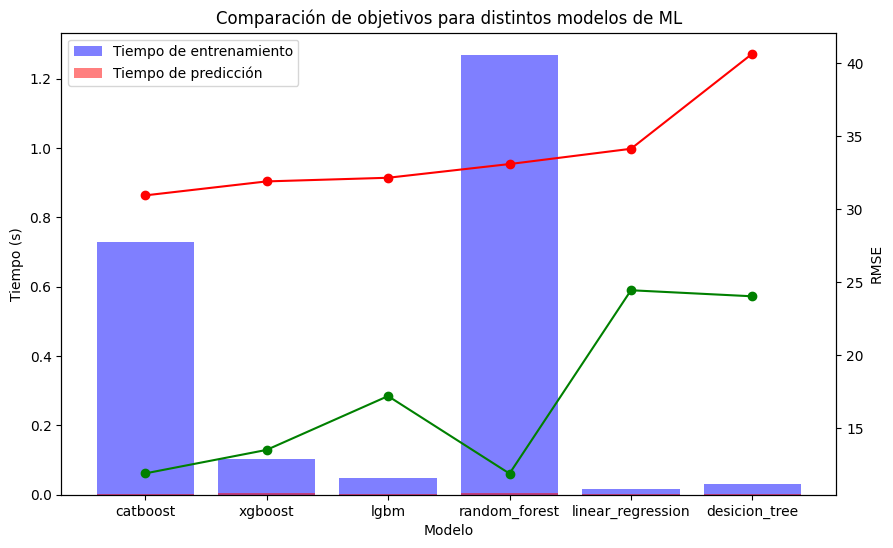

In [54]:
models_df = models_df.sort_values(by='rmse_validation')

plt.figure(figsize=(10, 6))

plt.bar(models_df['model'], models_df['training_time'], color='blue', alpha=0.5, label='Tiempo de entrenamiento')
plt.bar(models_df['model'], models_df['prediction_time'], color='red', alpha=0.5, label='Tiempo de predicción')
plt.title('Comparación de objetivos para distintos modelos de ML')
plt.ylabel('Tiempo (s)')
plt.xlabel('Modelo')
plt.legend(loc='upper left')

plt.twinx()
plt.plot(models_df['model'], models_df['rmse_train'], marker='o', color='green', label='RMSE de entrenamiento')
plt.plot(models_df['model'], models_df['rmse_validation'], marker='o', color='red', label='RMSE de validación')
plt.ylabel('RMSE')


plt.show()

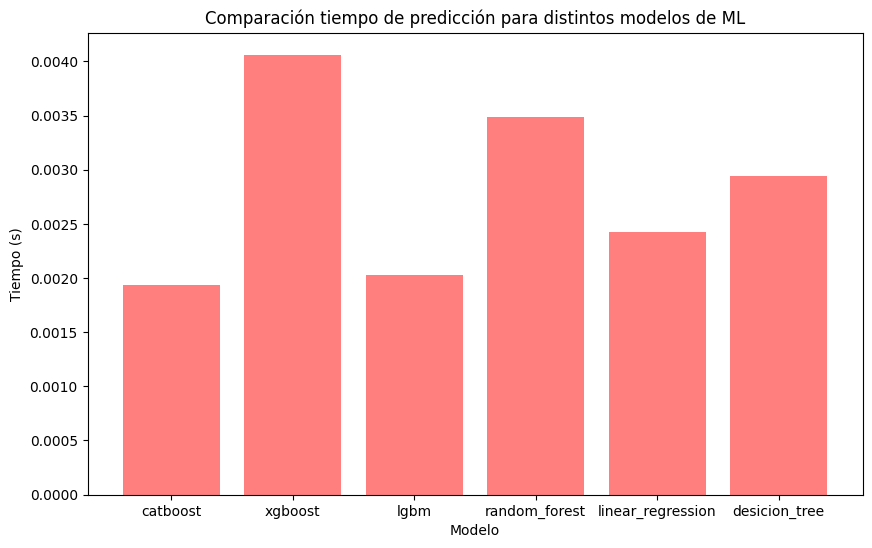

In [55]:
# Como los tiempos de prediccion son muy pequeños en comparación a los tiempos de entrenamiento 
# Se realiza este gráfico para evaluar cual posee la mejor performance en este aspecto.
plt.figure(figsize=(10, 6))

plt.bar(models_df['model'], models_df['prediction_time'], color='red', alpha=0.5, label='Tiempo de predicción')
plt.title('Comparación tiempo de predicción para distintos modelos de ML')
plt.ylabel('Tiempo (s)')
plt.xlabel('Modelo')

plt.show()

Observaciones destacables:

- El modelo con mejor RMSE corresponde al modelo Catboost, aunque su tiempo de entrenamiento corresponde al segundo mas alto de los modelos y su tiempo de predicción es bastante promedio (aunque de por si los tiempos son bastante bajos con este nivel de datos)
- El segundo mejor viene a ser el modelo XGBoost, cuya diferencia en las metricas corresponde es muy baja, con la diferencia que el tiempo de entrenamiento es notablemente mas bajo y el de validación es el doble al Catboost.
- Todos los modelo respondieron de manera en su metricas, estando todos los valores por lo menos 8 puntos bajo el valor requerido de 48.

#### Analisis de predicciones

Teniendo en cuenta que son secuencias temporales, los resultados pueden ser facilmente visualizados a traves de un grafico, por lo que se verá como son las predicciones realizadas en cada modelo comparadas con el resultado real.

In [56]:
# Preparacion de datasets para modelo
df_validation_lr = pd.DataFrame(predictions_lr['test'], index=target_validation.index, columns=['num_orders'])
df_validation_dt = pd.DataFrame(predictions_dt['test'], index=target_validation.index, columns=['num_orders'])
df_validation_rf = pd.DataFrame(predictions_rf['test'], index=target_validation.index, columns=['num_orders'])
df_validation_lgbm = pd.DataFrame(predictions_lgbm['test'], index=target_validation.index, columns=['num_orders'])
df_validation_cb = pd.DataFrame(predictions_cb['test'], index=target_validation.index, columns=['num_orders'])
df_validation_xgb = pd.DataFrame(predictions_xgb['test'], index=target_validation.index, columns=['num_orders'])

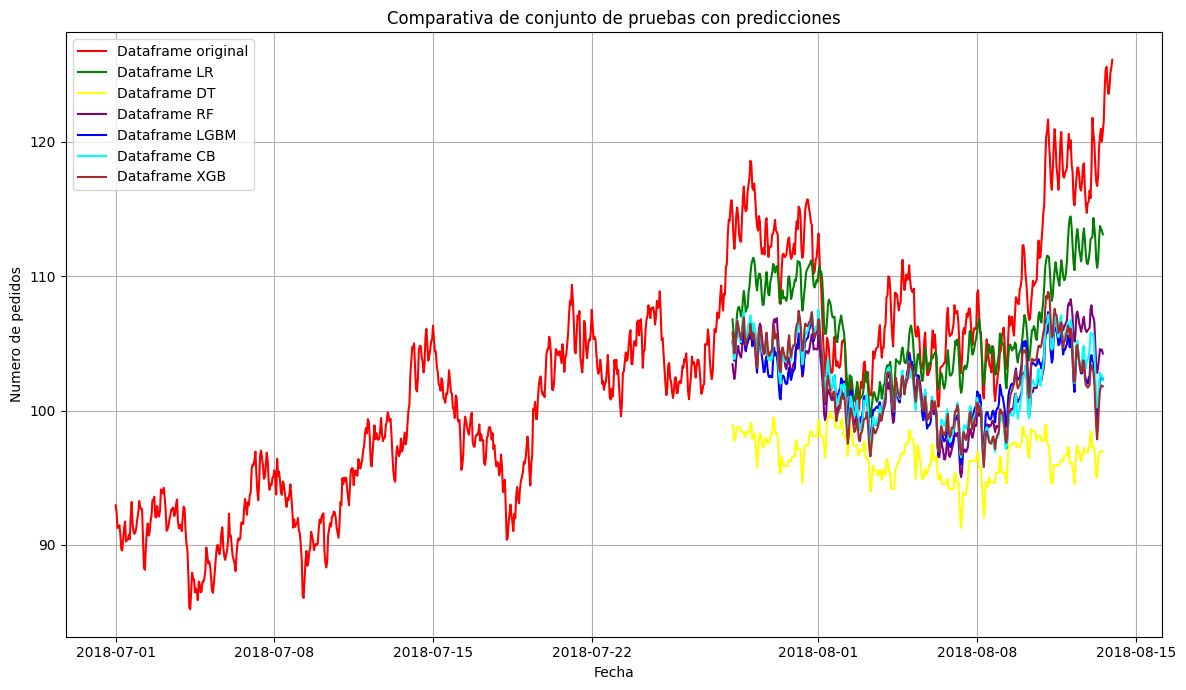

In [57]:

plt.figure(figsize=(12, 7))

plt.plot(df.loc['2018-07-01':'2018-08-13'].index, df['num_orders'].rolling(50).mean().loc['2018-07-01':'2018-08-13'], label='Dataframe original', color='red')
plt.plot(df_validation_lr.index, df_validation_lr['num_orders'].rolling(50).mean(), label='Dataframe LR', color='green')
plt.plot(df_validation_dt.index, df_validation_dt['num_orders'].rolling(50).mean(), label='Dataframe DT', color='yellow')
plt.plot(df_validation_rf.index, df_validation_rf['num_orders'].rolling(50).mean(), label='Dataframe RF', color='purple')
plt.plot(df_validation_lgbm.index, df_validation_lgbm['num_orders'].rolling(50).mean(), label='Dataframe LGBM', color='blue')
plt.plot(df_validation_cb.index, df_validation_cb['num_orders'].rolling(50).mean(), label='Dataframe CB', color='cyan')
plt.plot(df_validation_xgb.index, df_validation_xgb['num_orders'].rolling(50).mean(), label='Dataframe XGB', color='brown')

plt.title('Comparativa de conjunto de pruebas con predicciones')
plt.xlabel('Fecha')
plt.ylabel('Numero de pedidos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Prueba de modelo elegido

 <div class="alert alert-block alert-info">

 <b>Aaquí relizaré la la prediccion al conjunto de pruebas, aunque tengo una duda con respecto a como proceder, por lo que procede´re a realizar mis dos teorias.

 La primera es que debo realizar la predicción con el cual modelo entrenado y analilzar, lo cual en primera instancia me genera ruido, puesto que al ser una secuencia lineal, deberia tener los datos entrenados hasta el punto donde se quiere evaluar, aunque ante la duda la realizaré de todas formas para analizar su resultado.

 La segunda es la idea que me hace mas sentido, la cual es entrenar nuevamente el modelo con los datos hasta antes de la prueba (incluyendo los de validacion).
 
 </b> <a class="tocSkip"></a>

 </div>

In [58]:
# Primera propuesta de prueba
predictions_test_cb = model_cb.predict(features_test)

print('RMSE con conjunto de pruebas:')
rmse_validation_cb = print_rmse(target_test, predictions_test_cb)

RMSE con conjunto de pruebas:
El RMSE calculado es: 51.31


Como se puede esperar, el modelo al no ser consecutivo al el tiempo de pruebas, genera mayores errores, dejando la metrica fuera del valor minimo requerido.

In [59]:
# Segunda propuesta
features_train_val = pd.concat([features_train, features_validation])
target_train_val = pd.concat([target_train, target_validation])

times_cb, predictions_test_cb = train_pred_time(model_cb, features_train_val, target_train_val, features_test)

Tiempo de entrenamiento: 0.8049 s
Tiempo de predicción: 0.0016 s


In [60]:
print('RMSE con conjunto de pruebas:')
rmse_validation_cb = print_rmse(target_test, predictions_test_cb['test'])

RMSE con conjunto de pruebas:
El RMSE calculado es: 41.8


El modelo entrenado tanto con el conjunto de entrenamiento y validacion, obtiene un mejor desempeño, alcanzado el valor RMSE de requerido para pasar los requerimientos.

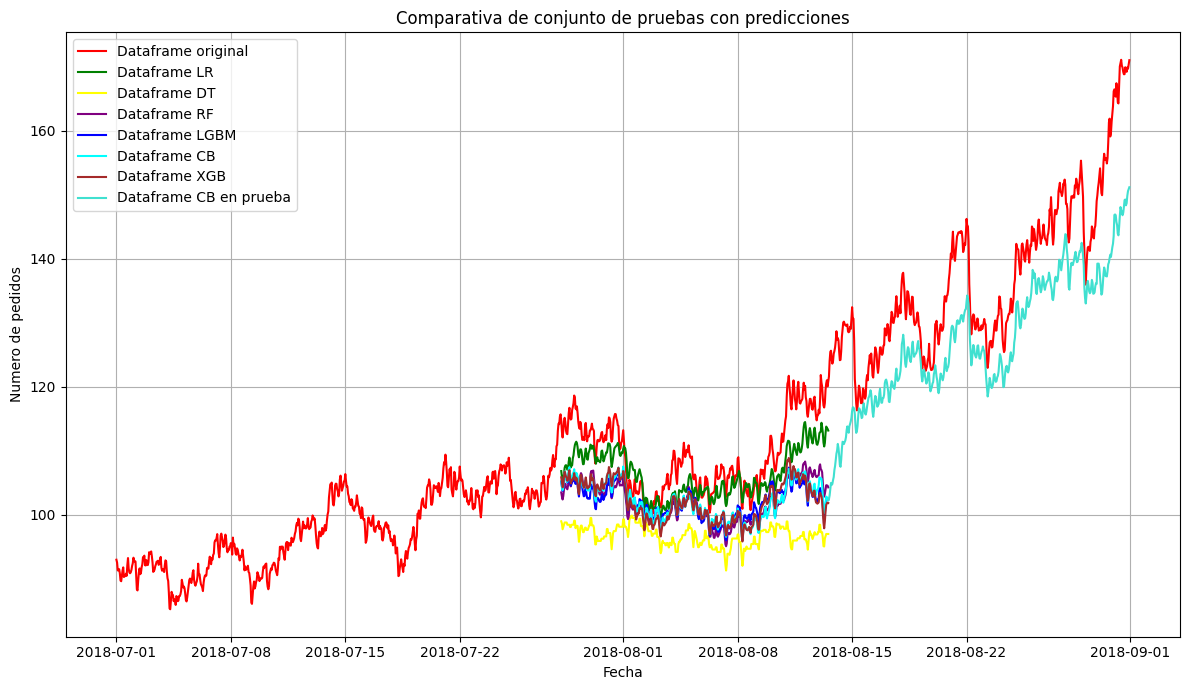

In [69]:
# Verificación gráfica de resultado
df_test_cb = pd.DataFrame(predictions_test_cb['test'], index=target_test.index, columns=['num_orders']) # Se crea df de predicciones de prueba
df_test_cb = pd.concat([df_validation_cb.tail(50), df_test_cb]) # Se insertan los ultimos 50 valores del df de validacion para continuidad del
# grafico ya que al ser una media movil de 50 puntos, se genera un salto

plt.figure(figsize=(12, 7))

# Grrafico real
plt.plot(df.loc['2018-07-01':].index, df['num_orders'].rolling(50).mean().loc['2018-07-01':], label='Dataframe original', color='red')

# Grafico de modelos de validacion 
plt.plot(df_validation_lr.index, df_validation_lr['num_orders'].rolling(50).mean(), label='Dataframe LR', color='green')
plt.plot(df_validation_dt.index, df_validation_dt['num_orders'].rolling(50).mean(), label='Dataframe DT', color='yellow')
plt.plot(df_validation_rf.index, df_validation_rf['num_orders'].rolling(50).mean(), label='Dataframe RF', color='purple')
plt.plot(df_validation_lgbm.index, df_validation_lgbm['num_orders'].rolling(50).mean(), label='Dataframe LGBM', color='blue')
plt.plot(df_validation_cb.index, df_validation_cb['num_orders'].rolling(50).mean(), label='Dataframe CB', color='cyan')
plt.plot(df_validation_xgb.index, df_validation_xgb['num_orders'].rolling(50).mean(), label='Dataframe XGB', color='brown')

# Grafico de modelo de pruebas
plt.plot(df_test_cb.index, df_test_cb['num_orders'].rolling(50).mean(), label='Dataframe CB en prueba', color='Turquoise')

plt.title('Comparativa de conjunto de pruebas con predicciones')
plt.xlabel('Fecha')
plt.ylabel('Numero de pedidos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo, si bien un poco mas conservador, representa fielmente los patrones de los valores reales.

## Conclusiones

En este proyecto se pusieron a prueba los metodos de entrenamiento de modelos de ML que ya se han estado utilizando hace ya algunos sprints, pero visto de una perspectiva mas lineal. 

Se probaron distintos modelos con metodos ya utilizados anteriormente, y los resultados cumplen con las espectativas.

Finalmente se decide elegir el modelo Catboost por su mejor deempeño tanto en tiempo como en metrica y resultado final con el conjunto de pruebas.